# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is for model training and testing

#### Import python library

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#Import models from scikit learn module:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

import h5py
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model 

import pickle
import joblib
import os

from ModelDefinitions import createModel

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
    #*********************************
    # Index 00-10 is for LSTM Model
    # Index 11-20 is for Bi-LSTM Model
    # Index 21-30 is for CNN Model
    #*********************************

# ------ CHANGE THESE ------
index = 0
seed  = 7
np.random.seed(seed)
basemodelname = 'LSTM1-3in2out'
batch_size    = 4096
no_of_epoch   = 20
no_of_train   = 0.8
# --------------------------

# choose a number of time steps
n_steps_in, predict_next_no_of_output = 3, 2

modelname = basemodelname + "_" + str(index)
filepath  = 'model/' + modelname + ".hdf5"

## Define Functions

In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


## Read in Dataset

In [6]:
xls  = pd.ExcelFile('data/Dataset_feature.xlsx')
data = pd.read_excel(xls, 'TrafficMgmt')
data

,day,hour,min,dow,lat,long,demand
0,0.283333,0.869565,0.000000,0.285714,0.533333,0.171429,0.020072
1,0.150000,0.608696,0.666667,0.285714,0.288889,0.200000,0.024721
2,0.133333,0.260870,0.333333,0.142857,0.644444,0.828571,0.102821
3,0.516667,0.217391,0.000000,0.000000,0.533333,0.428571,0.088755
4,0.233333,0.173913,0.000000,1.000000,0.288889,0.342857,0.074468
...,...,...,...,...,...,...,...
1048570,0.083333,0.347826,0.666667,0.857143,0.911111,0.771429,0.024022
1048571,0.366667,0.652174,0.666667,1.000000,0.111111,0.400000,0.005703
1048572,0.683333,0.652174,1.000000,0.285714,0.533333,0.200000,0.067131
1048573,0.016667,0.260870,0.666667,0.285714,0.711111,0.600000,0.151323


In [7]:
predictor_var = ['day','hour','min','dow','lat','long']
outcome_var   = 'demand'
no_of_features = len(predictor_var)

#### Prepare training & test data

In [8]:
dataset = data.to_numpy()
dataset

array([[0.28333333, 0.86956522, 0.        , ..., 0.53333333, 0.17142857,
        0.02007179],
       [0.15      , 0.60869565, 0.66666667, ..., 0.28888889, 0.2       ,
        0.02472097],
       [0.13333333, 0.26086957, 0.33333333, ..., 0.64444444, 0.82857143,
        0.10282096],
       ...,
       [0.68333333, 0.65217391, 1.        , ..., 0.53333333, 0.2       ,
        0.06713131],
       [0.01666667, 0.26086957, 0.66666667, ..., 0.71111111, 0.6       ,
        0.15132309],
       [0.06666667, 0.43478261, 1.        , ..., 0.68888889, 0.8       ,
        0.02600688]])

In [9]:
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, predict_next_no_of_output)
print(X.shape, y.shape)

(1048572, 3, 6) (1048572, 2)


#### Train-test-val dataset split

In [10]:
X_train1 = X[:int(no_of_train*len(X))]
y_train1 = y[:int(no_of_train*len(X))]
X_test  = X[int(no_of_train*len(X)):]
y_test  = y[int(no_of_train*len(X)):]

X_train = X_train1[:int(no_of_train*len(X_train1))]
y_train = y_train1[:int(no_of_train*len(X_train1))]
X_val   = X_train1[int(no_of_train*len(X_train1)):]
y_val   = y_train1[int(no_of_train*len(X_train1)):]

In [11]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(671085, 3, 6) (671085, 2) (209715, 3, 6) (209715, 2) (167772, 3, 6) (167772, 2)


### Main Program

In [12]:
def main():
    
    #*********************************
    # Index 00-10 is for LSTM Model
    # Index 11-20 is for Bi-LSTM Model
    # Index 21-30 is for CNN Model
    #*********************************

    # Create model and summary
    model = createModel(X_train, predict_next_no_of_output, index) #
    model.summary()
    
    # Create checkpoint for the training
    # This checkpoint performs model saving when
    # an epoch gives highest testing accuracy  
    checkpoint     = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min') 
    
    # Log the epoch detail into csv
    csv_logger     = CSVLogger(modelname + '.csv')
    callbacks_list = [checkpoint,csv_logger]

    # steps_per_epoch = total training data across all classes / batch size
    # validation_steps = number of batches in validation dataset defining 1 epoch
    # The line for training
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=no_of_epoch, 
                        batch_size=batch_size,
                        shuffle=False,
                        callbacks=callbacks_list) 

main()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 3, 64)             18176     
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 64)             256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 1024)           4460544   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 1024)           4096      
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 1024)           4096  

### Load saved trained model and scalar

In [13]:
# Load your own trained model & scaler
model           = load_model(filepath, compile = False)
scaler_filename = "grab_msft_scaler.save"
scaler          = joblib.load(scaler_filename) 

### Test dataset test result

In [14]:
predicted_value = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,predicted_value)))

0.16833317805780187


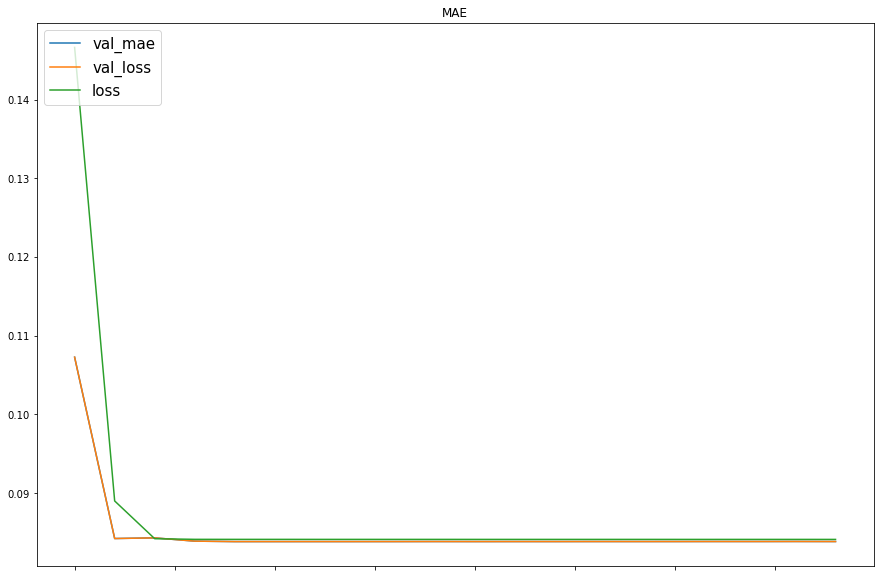

In [15]:
records     = pd.read_csv(modelname +'.csv')
plt.figure(figsize=(15,10))

ax          = plt.gca()
ax.set_xticklabels([])

plt.plot(records['val_mae'],label="val_mae")
plt.plot(records['val_loss'],label="val_loss")
plt.plot(records['loss'],label="loss")
plt.title('MAE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

plt.show()

### Sample Testing 

In [18]:
xls  = pd.ExcelFile('data/test_sample8000.xlsx')
test_sample = pd.read_excel(xls, 'TrafficMgmt')

# Apply Standardscalar to sample test data
test_sample[predictor_var] = scaler.fit_transform(test_sample[predictor_var])

In [19]:
# covert into input/output
test_sample_array = test_sample.to_numpy()
X_sample, y_sample = split_sequences(test_sample_array, n_steps_in, predict_next_no_of_output)
print(X_sample.shape, y_sample.shape)

(17, 3, 6) (17, 2)


In [20]:
predicted_value = model.predict(X_sample)
print('Predicted value : {} \n Actual Value    : {}' .format(predicted_value,y_sample))

Predicted value : [[0.05051381 0.04963513]
 [0.04982841 0.05055901]
 [0.04926909 0.04697861]
 [0.04958403 0.0501419 ]
 [0.05066487 0.04973871]
 [0.0511458  0.04956186]
 [0.04899543 0.04908208]
 [0.04956262 0.05013169]
 [0.04965325 0.05025402]
 [0.04956618 0.05007203]
 [0.04948215 0.04996168]
 [0.05077944 0.04984472]
 [0.05031962 0.04956447]
 [0.04975304 0.05046107]
 [0.04953884 0.05009311]
 [0.04955467 0.05010164]
 [0.04925036 0.04959133]] 
 Actual Value    : [[4.11381160e-02 6.28299090e-02]
 [6.28299090e-02 1.59614780e-01]
 [1.59614780e-01 9.09941638e-01]
 [9.09941638e-01 9.01061000e-04]
 [9.01061000e-04 1.32621545e-01]
 [1.32621545e-01 1.93137866e-01]
 [1.93137866e-01 4.08696860e-02]
 [4.08696860e-02 2.04278450e-02]
 [2.04278450e-02 6.94884150e-02]
 [6.94884150e-02 4.17434120e-02]
 [4.17434120e-02 1.90697068e-01]
 [1.90697068e-01 2.86340264e-01]
 [2.86340264e-01 6.49010570e-02]
 [6.49010570e-02 9.24329596e-01]
 [9.24329596e-01 7.57118120e-02]
 [7.57118120e-02 5.34953510e-02]
 [5.3495

In [21]:
print(np.sqrt(mean_squared_error(y_sample,predicted_value)))

0.30938402424303935


### Testing using 1 row of inference data

In [25]:
# Data input sequence format :
test_data1  = [[18,20, 0, 4, -5.353088, 90.653687],
               [10,14,30, 3, -5.413513, 90.664673],
               [ 9, 6,15, 2, -5.325623, 90.906372]]
test_data2  = [[32, 5, 0, 4, -5.353088, 90.752563],
               [15, 4, 0, 1, -5.413513, 90.719604],
               [ 1,12,15, 1, -5.336609, 90.609741]]
test_data3  = [[25, 3,30, 4, -5.391541, 90.818481],
               [51,20,45, 2, -5.408020, 90.631714],
               [48, 6,15, 6, -5.364075, 90.763550]]
test_data4  = [[ 4,22,15, 4, -5.402527, 90.675659],
               [45, 9,15, 3, -5.402527, 90.917358],
               [52,11,45, 3, -5.364075, 90.664673]]
test_data5  = [[46,12,15, 4, -5.353088, 90.642700],
               [34,14,45, 6, -5.375061, 90.807495],
               [40, 2,30, 5, -5.424500, 90.785522]]
test_data6  = [[14,14,45, 0, -5.391541, 90.598755],
               [27, 3,30, 6, -5.320129, 90.785522],
               [ 6,23,45, 6, -5.358582, 90.752563]]
test_data7  = [[48,11,30, 6, -5.391541, 90.609741],
                [17,23,45, 3, -5.292664, 90.829468],
                [56,10, 0, 0, -5.413513, 90.774536]]

test_target1 = [[0.102821],[0.088755]]
test_target2 = [[0.023843],[0.007460]]
test_target3 = [[0.054170],[0.123463]]
test_target4 = [[0.359406],[0.514136]]
test_target5 = [[0.026409],[0.013998]]
test_target6 = [[0.029400],[0.057255]]
test_target7 = [[0.008772],[0.119240]]

#### First set of testdata

In [26]:
Data_scaled = scaler.transform(test_data1)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target1))

Predicted value : [[0.05032932 0.04958412]]
Actual Value    : [[0.102821], [0.088755]]


In [27]:
Data_scaled = scaler.transform(test_data2)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target2))

Predicted value : [[0.04769095 0.04539163]]
Actual Value    : [[0.023843], [0.00746]]


In [28]:
Data_scaled = scaler.transform(test_data3)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target3))

Predicted value : [[0.04954189 0.05007146]]
Actual Value    : [[0.05417], [0.123463]]


In [29]:
Data_scaled = scaler.transform(test_data4)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target4))

Predicted value : [[0.0503199  0.04957758]]
Actual Value    : [[0.359406], [0.514136]]


In [30]:
Data_scaled = scaler.transform(test_data5)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target5))

Predicted value : [[0.05047073 0.0495757 ]]
Actual Value    : [[0.026409], [0.013998]]


In [31]:
Data_scaled = scaler.transform(test_data6)
Data_scaled = Data_scaled.reshape(1,n_steps_in,no_of_features)
predicted_value = model.predict(Data_scaled)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target6))

Predicted value : [[0.04937553 0.04984155]]
Actual Value    : [[0.0294], [0.057255]]
